In [11]:
import warnings

warnings.filterwarnings("ignore")

from common_utils.utils.config import Config
from common_utils.io.data_access.data_access_factory import DataAccessFactory

# from axpo_trading.forecast.forecast_preprocess_iberia import preproces_ufis
from common_utils.utils import utils, utils_io, utils_date
from axpo_trading.forecast import forecast_sql_preprocess_iberia
from axpo_trading.forecast import forecast_preprocess_iberia
import pandas as pd
import numpy as np
import os
import datetime
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Random seeds
from numpy.random import seed

seed(42)
from tensorflow.keras.utils import set_random_seed

set_random_seed(42)
import random as rn

rn.seed(1254)
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError

# wind_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
wind_path = "/home/jovyan/projects/AdvancedAnalytics-UseCase-Wind"
os.chdir(wind_path)

os.environ["CONFIG_DIR"] = "config_files"
os.environ["AUTH_CONFIG_DIR"] = "auth"
os.environ["AZURE_STORAGE_ACCOUNT_RAW_CONTAINER_NAME_WIND_RAW"] = "raw"
os.environ["AZURE_STORAGE_ACCOUNT_RAW_CONTAINER_NAME_WIND_STAGING"] = "staging"
os.environ[
    "AZURE_SQL_SHARED_RAW_SERVER"
] = "axso-prod-appl-aa-prod-shared-sql-secondary.database.windows.net"
# os.environ["AZURE_SQL_SHARED_RAW_SERVER"] = 'axso-prod-appl-aa-prod-shared-sql.database.windows.net'
os.environ["AZURE_SQL_SHARED_RAW_DATABASE"] = "axso-prod-appl-aa-prod-shared-raw-sqldb"
os.environ["N_THREADS_SQL"] = "1"

# DEV
os.environ["ENV"] = "azure_iberia_k8s_dev"
# BLOB DEV
os.environ["AZURE_STORAGE_ACCOUNT_DATA_NAME"] = "axsonpaadevdslabdls"
os.environ["AZURE_STORAGE_ACCOUNT_RAW_NAME"] = "axsoprodaaprodshareddls-secondary"
os.environ["AZURE_STORAGE_ACCOUNT_DATA_CONTAINER_NAME_WIND_REFINED"] = "wind-refined"
os.environ["AZURE_STORAGE_ACCOUNT_DATA_CONTAINER_NAME_WIND_RESULTS"] = "wind-results"

In [4]:
date_from_train = "2020-03-01"
date_to_train = "2020-04-01"
# date_from_train = "2018-07-31"
# date_to_train = "2023-10-31"
# date_from_train = "2021-01-01"
# date_to_train = "2021-05-20"

date_from_validate = "2019-11-01"
date_to_validate = "2019-12-31"

date_from_test = "2020-01-01"
date_to_test = "2020-02-01"


n_steps_in = 12
# n_steps_out = 3
n_steps_out = 3

portfolio_level = True

main_premaster_columns = ["datetime_market","datetime","hours_fwd","ufi","telemetry","forecast","metering"]
info_columns = ["telemetry","forecast","metering","forecast_error_metering","forecast_error_telemetry"]
groupping_columns = ['ufi','hours_fwd']
target_hours_fwd = [1,2,3]
# target_ufis = ["ZAPATER","PEARBO","ROMERA"]
# target_ufis = ["ABELLA","PAXAMON","SPADRON","PELALIN","TIGUEIR","PEIRIXO","MONTCEO","MONTOUT"]
target_ufis= ['ABELLA', 'CERROS', 'LAMESA', 'LACAYA', 'VILACHA', 'TIGUEIR',
       'ESQUILE', 'BRULLES', 'PELALIN', 'PESLOB', 'VISOS', 'DEFERII',
       'PECORTI', 'LASORDA', 'ESCANDO', 'BAYO', 'HINOJII',
       'PEOCHAO', 'CALERA', 'CPELAOS', 'ELGALLO', 'SPADRON', 'PAXAMON',
       'TRAPERA', 'SABUCED', 'PEZARZU', 'PESLOA', 'ASNEVES', 'CAMPANA',
       'PECOUTE', 'HINOJAI', 'PESLOD', 'AXIABRE', 'FEIXOS', 'OTERO',
       'POTRA', 'ZARZUEL', 'CERCEDA', 'GRAIADE', 'PEOUROL', 'RODERA',
       'MONTOUT', 'ARTEIXO', 'ELLLAN', 'MONTCEO', 'LALOMBA',
       'PEIRIXO', 'ATALAYA', 'FRAILA', 'DEHESII', 'MONTERO', 'MONDONE',
       'ROMERA', 'ESE', 'BANDELE', 'SANJOSE', 'SERRETA', 'DEHEII',
       'AEROGEN', 'ZAPATER', 'LARUYA', 'PESLOC', 'PEARBO', 'PELALOM',
       'MUDEFER']

## Functions

### Load time master

In [5]:
def pivot_master_by_levels(multiple_line_df):

    # TODO Parametrize levels

    # Pivot data according to level
    # Level 1: market dependent columns
    index_cols = ["datetime_market"]
    market_level_columns = ["hour_market"]
    reduced_df_lv_1 = multiple_line_df[market_level_columns + index_cols]
    reduced_df_lv_1["day_market"] = multiple_line_df["datetime_market"].dt.day
    reduced_df_lv_1["month_market"] = multiple_line_df["datetime_market"].dt.month
    # Add missing levels to even the final shapes
    reduced_df_lv_1 = reduced_df_lv_1.drop_duplicates()
    reduced_df_lv_1 = reduced_df_lv_1.set_index(index_cols, drop=True)
    even_level_1_arrays = [
        market_level_columns + ["day_market", "month_market"],
        [""],
        [""]
    ]
    reduced_df_lv_1.columns = pd.MultiIndex.from_product(even_level_1_arrays, names=["feature", "ufi", "hours_fwd"])

    # Level 2: ufi dependent columns
    index_cols = index_cols + ["ufi"]
    ufi_level_columns = ["p_max", "p_min", "telemetry", "telemetry_pct_good", "telemetry_open", "telemetry_close", "telemetry_min", "telemetry_max", "telemetry_std", "telemetry_value_count", "telemetry_slope", "lat","lon"] # "codCliente", "up", 
    reduced_df_lv_2 = multiple_line_df[ufi_level_columns + index_cols]
    reduced_df_lv_2 = reduced_df_lv_2.drop_duplicates(subset=["datetime_market","ufi"])
    reduced_df_lv_2 = reduced_df_lv_2.pivot(index=['datetime_market'], columns=['ufi'], values=ufi_level_columns)
    # Add missing level to even the shapes
    even_level_2_arrays = [
        list(reduced_df_lv_2.columns.get_level_values(0)),
        list(reduced_df_lv_2.columns.get_level_values(1)),
        list([""] * reduced_df_lv_2.columns.shape[0])
    ]
    even_level_2_tuples = list(zip(*even_level_2_arrays))
    reduced_df_lv_2.columns = pd.MultiIndex.from_tuples(even_level_2_tuples, names=["feature", "ufi", "hours_fwd"])
    reduced_df_lv_2

    # Level 3: horizon dependent columns
    index_cols = index_cols + ["hours_fwd"]
    horizon_level_columns = ["forecast","metering"] #,"forecast_error_metering" ,"forecast_error_telemetry"]
    reduced_df_lv_3 = multiple_line_df[horizon_level_columns + index_cols]
    reduced_df_lv_3 = reduced_df_lv_3.drop_duplicates()
    reduced_df_lv_3 = reduced_df_lv_3.pivot(index=['datetime_market'], columns=['ufi','hours_fwd'], values=horizon_level_columns)

    pivotted_df = pd.concat([reduced_df_lv_1,  pd.concat([reduced_df_lv_2, reduced_df_lv_3], axis=1)], axis=1)

    return pivotted_df



def add_forecast_error_pivot(pivot_df, error_reference="telemetry"):

    ufis_in_df = pivot_df.columns.get_level_values("ufi").unique()
    # Remove empty ufi used for even levels
    ufis_in_df = [ufi for ufi in ufis_in_df if ufi]
    fcst_error_df = pd.DataFrame()
    fcst_error_df_partial = pd.DataFrame()

    for ufi in ufis_in_df:

        if error_reference == "telemetry":
            # Telemetry aligned with index hour (it comes with 1 hour lag)
            telemetry_market_t = pivot_df[error_reference,ufi].shift(-1)
            # Forecasted production aligned with the index hour (we take the t+1 forecast)
            forecast_market_t = pivot_df["forecast",ufi,1].shift(1)
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = forecast_market_t - telemetry_market_t
            # Lag the forecast error 1 hour so it is available at prediction time
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = fcst_error_df_partial[f"forecast_error_{error_reference}"].shift(1)
        else:
            # Error with respect to Metering  which is already aligned
            metering_market_t = pivot_df[error_reference,ufi,1]
            forecast_market_t = pivot_df["forecast",ufi,1]
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = forecast_market_t - metering_market_t
            # Lag the forecast error 1 hour so it is available at prediction time
            fcst_error_df_partial[f"forecast_error_{error_reference}"] = fcst_error_df_partial[f"forecast_error_{error_reference}"]


        fcst_error_df_partial["ufi"] = ufi
        fcst_error_df = pd.concat([fcst_error_df, fcst_error_df_partial])

    fcst_error_df = fcst_error_df.pivot(columns=['ufi'], values=[f"forecast_error_{error_reference}"])

    # Add missing level to even the shapes
    even_level_2_arrays = [
        list(fcst_error_df.columns.get_level_values(0)),
        list(fcst_error_df.columns.get_level_values(1)),
        list([""] * fcst_error_df.columns.shape[0])
    ]
    even_level_2_tuples = list(zip(*even_level_2_arrays))
    fcst_error_df.columns = pd.MultiIndex.from_tuples(even_level_2_tuples, names=["feature", "ufi", "hours_fwd"])

    return pd.concat([fcst_error_df, pivot_df], axis=1)


def get_master(date_from, date_to, cols_to_keep, horizons, ufis, values_to_pivot, do_pivot=True):

    # Load premaster data
    config_dict = Config.get_config()
    factory = DataAccessFactory()
    data_config = config_dict["data_access_factory"]
    source = factory.get(data_config["master_overcost"]["source"])

    master = utils_io.load_monthly(
        path=f"forecast/research/premaster_eolic",
        date_col="date",
        date_from=date_from,
        date_to=date_to,
        data_access=source,
    )

    # Get sample of premaster
    if cols_to_keep == "all":
        cols_to_keep = master.columns
    reduced_df = master[cols_to_keep]
    # Get only info for the next three hours
    reduced_df = reduced_df[reduced_df["hours_fwd"].isin(horizons)]
    # Get only records for target ufis
    reduced_df = reduced_df[reduced_df["ufi"].isin(ufis)][cols_to_keep]
    # Drop columns with empty meterings
    reduced_df = reduced_df[reduced_df['metering'].notna()]
    # Add forecast_error_predict_time
#     reduced_df["forecast_error_metering"] = reduced_df["forecast"] - reduced_df["metering"]

    # The telemetry is not aligned with the forecast thus we cannot simply subtract
    #     reduced_df["forecast_error_telemetry"] = reduced_df["forecast"] - reduced_df["telemetry"]

    # ?Drop rows with empty forecast error since we cannot know their real values 
    reduced_df = reduced_df.drop_duplicates()
    if do_pivot:
        pivot_df = pivot_master_by_levels(reduced_df)
    else:
        return reduced_df

    # Now we can align the forecasts and telemetry at market time to get the recent forecast error
    pivot_df = add_forecast_error_pivot(pivot_df, error_reference="telemetry")
    pivot_df = add_forecast_error_pivot(pivot_df, error_reference="metering")

    # It's really important to determine the order of the columns since we will be working with their array representation, not the dataframe
    pivot_df = pivot_df.sort_index(axis='columns', level=[0,1,2])

    return pivot_df



### Split temporal sequences into observations

In [6]:
def split_sequences(sequences, n_steps_in, n_steps_out, target_col, portfolio_level=True):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :], sequences.iloc[end_ix:out_end_ix, :]

        # As a feature we have forecast error based on telemetry (real time proxy for meterings)
        seq_x = seq_x.rename(columns={"forecast_error_telemetry":"forecast_error"})
        # As a target we want the forecast error to be the based on the actual metering
        seq_y = seq_y.rename(columns={"forecast_error_metering":"forecast_error"})

        # Drop the spare forecast error and original meterings
        seq_x = seq_x.drop(["forecast_error_metering","metering"], axis=1)

        # OPTION 1. Predict all input time series
        # seq_y = seq_y.drop(["forecast_error_telemetry","metering"], axis=1)
        # OPTION 2. Predict only target col for each UFI
        seq_y = seq_y[target_col]
        # OPTION 3. Predict only taget col for complete Portfolio
        if portfolio_level:
            if target_col == "forecast":
                seq_y = seq_y.loc[:, (slice(None),1)]
            seq_y = seq_y.sum(axis=1)

        # Flatten col levels
        flatten_cols_x = ["-".join(str(cs) for cs in c) for c in seq_x.columns.to_series()]
        seq_x.columns = flatten_cols_x
        if not portfolio_level:
            flatten_cols_y = ["-".join(str(cs) for cs in c) for c in seq_y.columns.to_series()]
            seq_y.columns = flatten_cols_y

        X.append(seq_x.values)
        y.append(seq_y.values)

    X_arr = array(X)
    y_arr = array(y)

    if portfolio_level:
        y_arr = y_arr[:,:, np.newaxis]

    return X_arr, y_arr

### Feature embedding into grid

In [7]:
def temporal_to_scene_master(master_pivot, grid_coords, localized_ufis):
    """
    :param master_pivot: data to train in pivotted format (type: pd.DataFrame)
    :param grid_coords: grid of size unique_latitutes X unique longitudes
                        with the id of the ufi located in each index
                        (type: np.array)
    :param localized_ufis: contains corrdinate information about each ufi
                           in master_pivot: id - ufi_name - lat - lon
                           (type: pd.DataFrame)

    : returns scene_master: Size: [time steps] X [latitudes] X [longitudes] X [features]
              features_index: data to relable the features. Size: [features]
    """

    example_ufi = master_pivot.columns.get_level_values(1)[-1]
    features_index = master_pivot.iloc[0, master_pivot.columns.get_level_values(1) == example_ufi].index
    
    num_features = len(features_index)
    num_time_steps = master_pivot.shape[0]

    # scene_master = [time steps] X [latitudes] X [longitudes] X [features]
    # same as image = [frame] X [width] X [length] X [channels]
    scene_master = np.ones((num_time_steps, grid_coords.shape[0], grid_coords.shape[1], num_features))
    scene_master = scene_master * -1


    # Iterate over the whole grid
    for lat_idx in np.arange(0,grid_coords.shape[0]):
        for lon_idx in np.arange(0,grid_coords.shape[1]):
            # Check the id for the position
            id = grid_coords[lat_idx][lon_idx]
            if id != -1:
                # Lookup its corresponding ufi
                ufi = localized_ufis[localized_ufis["id"] == id]["ufi"].values[0]
                # Retrieve data for ufi at time t
                features_for_ufi_all_t = master_pivot.iloc[:, master_pivot.columns.get_level_values(1) == ufi].values
                
                if features_for_ufi_all_t.shape[1] > 0:

                    scene_master[:, lat_idx, lon_idx, :] = features_for_ufi_all_t

    return scene_master, features_index



### Load scene master

In [8]:
def get_master_scene(date_from, date_to, cols_to_keep, horizons, ufis, values_to_pivot, ufi_grid, ufi_location_summary, scaler=None):

    master_time = get_master(date_from, date_to, cols_to_keep, horizons, ufis, values_to_pivot)
    
    # Get indexes for the features to be used in each list
    flattened_cols = ["-".join(str(cs) for cs in c) for c in master_time.columns.to_series()]
    features_idx = [flattened_cols.index(col) for col in flattened_cols if ("metering" not in col) & ("lat" not in col) & ("lon" not in col) & ("market" not in col)]
    features_idy = [flattened_cols.index(col) for col in flattened_cols if ("forecast_error_metering" in col)]
    # Scale input features
    print(f"Scaling data from {date_from} to {date_to}")
    if scaler is None:
        print(f"No scaler found, generating Scaler on data from {date_from} to {date_to}")
        scaler = MinMaxScaler()
        master_time.iloc[:,features_idx] = scaler.fit_transform(master_time.iloc[:,features_idx])
    else:
        print(f"Using existing scaler on data from {date_from} to {date_to}")
        master_time.iloc[:,features_idx] = scaler.transform(master_time.iloc[:,features_idx])
        
    master_scene, features_index = temporal_to_scene_master(master_time, ufi_grid, ufi_location_summary)

    return master_scene, features_index, scaler


### Split scene sequences into observations

In [9]:
def split_sequences_scenes(sequences, n_steps_in, n_steps_out, target_col, features_index, portfolio_level=True):
    X, y = list(), list()
    # Get indexes for the features to be used in each list
    flattened_cols = ["-".join(str(c[i]) for i in [0,2]) for c in features_index.to_series()]
    features_idx = [flattened_cols.index(col) for col in flattened_cols if ("metering" not in col) & ("lat" not in col) & ("lon" not in col)]
    features_idy = flattened_cols.index(target_col)

    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break

        # Divide the master rows for the current observation: observed vs predicted
        # Keep the features in seq_x and the target in seq_y
        seq_x = sequences[i:end_ix, :,:,features_idx].copy()
        seq_y = sequences[end_ix:out_end_ix, :,:,features_idy].copy()

        # (NOT TESTED FOR Spatial model) OPTION 1. Predict all input time series
        # seq_y = seq_y.drop(["forecast_error_telemetry","metering"], axis=1)

        # OPTION 3. Predict only taget col for complete Portfolio
        if portfolio_level:
            # Mask nans as -1
            seq_y = np.nan_to_num(seq_y, nan=-1)
            # Substitue values of non existing ufis (marked as -1) by a 0
            np.place(seq_y, seq_y==-1, 0)
            # Sum all target values to get the portfolio value for each timestep
            seq_y = seq_y.sum(axis=1).sum(axis=1)

        X.append(seq_x)
        y.append(seq_y)

    X_arr = array(X)
    y_arr = array(y)

    if portfolio_level:
        y_arr = y_arr[:,:, np.newaxis]

    return X_arr, y_arr

## 1. Load needed data

### Load data

In [12]:
# Be sure to run Generate_Grid notebook first
# Load ufi list
ufi_location_summary = pd.read_csv('data/tfm/scenes/ufi_location_summary.csv')
# Load grid
ufi_grid = np.load('data/tfm/scenes/ufi_grid.npy')

### Load master train 

In [13]:
master_time = get_master(date_from_train, date_to_train, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns)

2023-02-09 18:09:13,232 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-09 18:09:13,269 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2020-03-01'
2023-02-09 18:09:13,370 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___201910_0.h5', 'premaster_eolic___202004_0.h5', 'premaster_eolic___202111_0.h5', 'premaster_eolic___201904_0.h5', 'premaster_eolic___202001_0.h5', 'premaster_eolic___202101_0.h5', 'premaster_eolic___201906_0.h5', 'premaster_eolic___201909_0.h5', 'premaster_eolic___202011_0.h5', 'premaster_eolic___202104_0.h5', 'premaster_eolic___202210_0.h5', 'premaster_eolic___201903_0.h5', 'premaster_eolic___201907_0.h5', 'premaster_eolic___202010_0.h5', 'premaster_eolic___202201_0.h5', 'premaster_eolic___201905_0.h5', 'premaster_eolic___202209_0.h5', 'premaster_eolic___202007_0.h5', 'premaster_eolic___202103_0.h5', 'premas

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/__init__.py:93: DeprecationWarning:

`np.typeDict` is a deprecated alias for `np.sctypeDict`.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:20: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:21: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:22: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:23: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/req_versions.py:24: Depre

2023-02-09 18:09:18,710 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___202004_0.h5'


In [14]:
master_time = pd.DataFrame()

In [ ]:
#get meterings from master_time

# Replace missing values with 0

# Sum at axis=1


In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(master_time[(master_time["datetime_market"])&(master_time["datetime_market"])], tsmode=True, sortby="Date Local")
profile.to_file('profile_report.html')


In [12]:
master_time.index.min()

Timestamp('2019-07-30 21:00:00')

In [13]:
master_time.index.max()

Timestamp('2019-10-31 22:00:00')

In [15]:
target_col = "forecast_error_metering-"

master_scene_train, features_index_train, train_feature_scaler = get_master_scene(date_from_train, date_to_train, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns, ufi_grid=ufi_grid, ufi_location_summary=ufi_location_summary)
X_train, y_train = split_sequences_scenes(master_scene_train, n_steps_in, n_steps_out, target_col, features_index_train, portfolio_level=True)

target_scaler = MinMaxScaler()
target_scaler.fit(y_train[:,0,:])

for i in np.arange(0,y_train.shape[1]):
    y_train[:,i,:] = target_scaler.transform(y_train[:,i,:])

2023-02-09 18:09:32,415 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-09 18:09:32,463 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2020-03-01'
2023-02-09 18:09:32,568 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___201910_0.h5', 'premaster_eolic___202004_0.h5', 'premaster_eolic___202111_0.h5', 'premaster_eolic___201904_0.h5', 'premaster_eolic___202001_0.h5', 'premaster_eolic___202101_0.h5', 'premaster_eolic___201906_0.h5', 'premaster_eolic___201909_0.h5', 'premaster_eolic___202011_0.h5', 'premaster_eolic___202104_0.h5', 'premaster_eolic___202210_0.h5', 'premaster_eolic___201903_0.h5', 'premaster_eolic___201907_0.h5', 'premaster_eolic___202010_0.h5', 'premaster_eolic___202201_0.h5', 'premaster_eolic___201905_0.h5', 'premaster_eolic___202209_0.h5', 'premaster_eolic___202007_0.h5', 'premaster_eolic___202103_0.h5', 'premas

In [16]:
y_train[:,0,:]

array([[0.31812412],
       [0.18713224],
       [0.14726507],
       [0.10894078],
       [0.09648644],
       [0.14171704],
       [0.2169029 ],
       [0.11506172],
       [0.30564016],
       [0.32367738],
       [0.38881895],
       [0.54690847],
       [0.51270076],
       [0.52406328],
       [0.49038323],
       [0.51195893],
       [0.81220951],
       [0.93636824],
       [1.        ],
       [0.63398964],
       [0.44192408],
       [0.56219254],
       [0.62854264],
       [0.47386449],
       [0.46197957],
       [0.41237636],
       [0.38689299],
       [0.25916618],
       [0.34938191],
       [0.33715046],
       [0.45580112],
       [0.38643675],
       [0.36921971],
       [0.39984711],
       [0.41884386],
       [0.37972198],
       [0.39231214],
       [0.37749128],
       [0.3318758 ],
       [0.29489411],
       [0.26804029],
       [0.33934982],
       [0.36423762],
       [0.35053468],
       [0.29079316],
       [0.21553069],
       [0.23681211],
       [0.112

### Load master validate 

In [18]:
master_scene_validate, features_index_validate, _ = get_master_scene(date_from_validate, date_to_validate, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns, ufi_grid=ufi_grid,ufi_location_summary=ufi_location_summary, scaler=train_feature_scaler)
X_validate, y_validate = split_sequences_scenes(master_scene_validate, n_steps_in, n_steps_out, target_col, features_index_validate, portfolio_level=True)

for i in np.arange(0,y_train.shape[1]):
    y_validate[:,i,:] = target_scaler.transform(y_validate[:,i,:])

2023-02-09 18:09:51,460 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-09 18:09:51,512 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2019-11-01'
2023-02-09 18:09:51,621 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___201910_0.h5', 'premaster_eolic___202004_0.h5', 'premaster_eolic___202111_0.h5', 'premaster_eolic___201904_0.h5', 'premaster_eolic___202001_0.h5', 'premaster_eolic___202101_0.h5', 'premaster_eolic___201906_0.h5', 'premaster_eolic___201909_0.h5', 'premaster_eolic___202011_0.h5', 'premaster_eolic___202104_0.h5', 'premaster_eolic___202210_0.h5', 'premaster_eolic___201903_0.h5', 'premaster_eolic___201907_0.h5', 'premaster_eolic___202010_0.h5', 'premaster_eolic___202201_0.h5', 'premaster_eolic___201905_0.h5', 'premaster_eolic___202209_0.h5', 'premaster_eolic___202007_0.h5', 'premaster_eolic___202103_0.h5', 'premas

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/pandas/compat/_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/array.py:245: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/jovyan/my-conda-envs/windTFM/lib/python3.7/site-packages/tables/atom.py:1227: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



2023-02-09 18:09:56,410 - MainThread - [INFO] - b'[UTILS IO] - get_files_without_sampling at line 398: Reading file premaster_eolic___201912_0.h5'
Scaling data from 2019-11-01 to 2019-12-31
Using existing scaler on data from 2019-11-01 to 2019-12-31


ValueError: operands could not be broadcast together with shapes (1466,960) (975,) (1466,960) 

In [ ]:
y_validate

## 2. Train model

In [ ]:
%reset_selective -f "^master_scene_train$"
# %reset_selective -f "^features_index_train$"
%reset_selective -f "^master_scene_validate$"
%reset_selective -f "^features_index_validate$"

In [19]:
from tensorflow import keras 
import tensorflow as tf
from keras import layers
from keras import Input, Model, metrics
from keras.layers import Dense, RepeatVector, TimeDistributed, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class EO_CNN_LSTM():

    def __init__(self, train_x, train_y, valid_x, valid_y):

#         self.n_features_in = train_x.shape[2]
#         self.n_features_out = train_y.shape[2]
#         self.n_steps_in = train_x.shape[1]
#         self.n_steps_out = train_y.shape[1]

        self.train_x = train_x
        self.train_y = train_y
        self.valid_x = valid_x
        self.valid_y = valid_y

        self.n_neurons = 10
        self.n_steps_out = 3
        self.n_features_out = 1
        self.dropout_ratio = 0.3

#         self.test_x_scaler_dict = {}
#         self.test_y_scaler_dict = {}

#     def scale_data(self, ts_arr, train=True, target=False):

#         if target:
#             scaler_dict = self.test_y_scaler_dict
#         else:
#             scaler_dict = self.test_x_scaler_dict

#         # Scale each time series separately
#         for col_i in np.arange(0,ts_arr.shape[2]):
#             if train:
#                 new_scaler = MinMaxScaler()
#                 ts_arr[:,:,col_i] = new_scaler.fit_transform(ts_arr[:,:,col_i])
#                 scaler_dict[col_i] = new_scaler
#             else:
#                 existing_scaler = scaler_dict[col_i]
#                 ts_arr[:,:,col_i] = existing_scaler.transform(ts_arr[:,:,col_i])

#         if target:
#             self.test_y_scaler_dict = scaler_dict
#         else:
#             self.test_x_scaler_dict = scaler_dict

#         return ts_arr

    def unscale_predictions(self, pred_arr):
        scaler_dict = self.test_y_scaler_dict
        for col_i in np.arange(0,pred_arr.shape[2]):
            scaler_obj = scaler_dict[col_i]
            pred_arr[:,:,col_i] = scaler_obj.inverse_transform(pred_arr[:,:,col_i])
        return pred_arr

    def get_model(self):

        input_layer = Input(shape=(None,*X_train.shape[2:]), name='input_layer')

        x = TimeDistributed(layers.Conv2D(15, (16,16), activation='relu'))(input_layer)
        x = TimeDistributed(layers.BatchNormalization())(x) ## 34X16X15
        x = TimeDistributed(layers.AveragePooling2D(pool_size=(4, 4)))(x)
        x = TimeDistributed(layers.Conv2D(30, (3,3), activation='relu'))(x) 
        x = TimeDistributed(layers.BatchNormalization())(x)
        x = TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2)))(x)
        x = TimeDistributed(layers.Conv2D(60, (2,2), activation='relu'))(x)
        x = TimeDistributed(layers.BatchNormalization())(x)
        # x = TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2)))(x)
        x = TimeDistributed(layers.Flatten())(x)
        lstm_1 = layers.LSTM(30, activation='relu', name="LSTM_Layer_1")(x)
        repeat_vector = RepeatVector(3, name="Repeating_Vector_Layer")(lstm_1)
        lstm_2 = layers.LSTM(30, activation='relu', return_sequences=True, name="LSTM_Layer_2")(repeat_vector)
        lstm_3 = layers.LSTM(30, activation='relu', return_sequences=True, name="LSTM_Layer_3")(lstm_2)
        dense = layers.Dense(30, activation="relu",name='Dense_Layer')
        dropout = layers.Dropout(0.3, input_shape=(2,))(lstm_3)
        time_dist = TimeDistributed(dense, name='Time_Distributed_Layer')(dropout)

        model = Model(inputs=input_layer, outputs=time_dist)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.mse])


    def get_model_conv(self):
        inp = layers.Input(shape=(n_steps_in,*X_train.shape[2:]))
#         x = layers.ConvLSTM2D(
#             filters=40,
#             kernel_size=(3, 3),
#             padding="same",
#             return_sequences=True,
#             activation="relu",
#         )(inp)
#         x = layers.BatchNormalization()(inp)
#         x = layers.AveragePooling3D(pool_size=(1, 3, 3), padding='same')(x)
        x = layers.ConvLSTM2D(
            filters=3,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(inp)
        x = layers.BatchNormalization()(x)
#         x = layers.AveragePooling3D(pool_size=(1, 3, 3), padding='same')(x)
#         x = layers.ConvLSTM2D(
#             filters=10,
#             kernel_size=(1, 1),
#             padding="same",
#             return_sequences=True,
#             activation="relu",
#         )(x)
#         x = layers.AveragePooling3D(pool_size=(1, 2, 2), padding='same')(x)
        flatten = tf.keras.layers.Flatten()
        x = TimeDistributed(flatten)(x)
#         dropout = Dropout(.3)
#         dense_1 = Dense(256,activation="relu")
#         dense_2 = Dense(32,activation="relu")
        dense_3 = Dense(1,activation="relu")
#         x = TimeDistributed(dense_1)(x)
#         x = TimeDistributed(dense_2)(x)
#         x = TimeDistributed(Dropout(.3))(x)
        x = TimeDistributed(dense_3)(x)

        model = keras.models.Model(inp, x)
        model.compile(
            loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=0.01),
        )
        self.model = model
        return self.model


    def train(self, epochs=1, scale_data=True):

        log_dir = "tensor_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        mcp_save = tf.keras.callbacks.ModelCheckpoint('data/tfm/scenes/cnn_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=5, min_lr=0.0001)
        early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

#         if scale_data:
#             train_x = self.scale_data(self.train_x)
#             train_y = self.scale_data(self.train_y, target=True)
#             valid_x = self.scale_data(self.valid_x, train=False)
#             valid_y = self.scale_data(self.valid_y, train=False, target=True)
#         else:
#             train_x = self.train_x
#             train_y = self.train_y
#             valid_x = self.valid_x
#             valid_y = self.valid_y
        train_x = self.train_x
        train_y = self.train_y
        valid_x = self.valid_x
        valid_y = self.valid_y

        train_x = np.nan_to_num(train_x, nan=-1)
        train_y = np.nan_to_num(train_y, nan=-1)
        valid_x = np.nan_to_num(valid_x, nan=-1)
        valid_y = np.nan_to_num(valid_y, nan=-1)

        # Define some callbacks to improve training.
        # reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
        batch_size = 150
        hist = self.model.fit(
                    train_x,
                    train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(valid_x, valid_y),
                    callbacks=[early_stopping, tensorboard_callback, mcp_save, reduce_lr],# reduce_lr],
                    verbose=1
                )

        self.hist = hist
        return hist

    def predict(self, data, scale_data=True):
        # print(f"Desc of predicted data BEFORE SCALING is: {pd.DataFrame(data[:,1,:]).describe().loc['mean',:3]}")
#         if scale_data:
#             data = self.scale_data(data, train=False, target=False)
        #  print(f"Desc of predicted data is: {pd.DataFrame(data[:,1,:]).describe().loc['mean',:3]}")
        data = np.nan_to_num(data, nan=-1)
        predicted = self.model.predict(data)
        predicted = np.where(predicted == -1, np.nan, predicted)

#         if scale_data:
#             predicted = self.unscale_predictions(predicted)

        return predicted


In [21]:
cnn_lstm_i = EO_CNN_LSTM(X_train, y_train, X_train, y_train)
cnn_lstm_i.get_model()
cnn_lstm_i_summary = cnn_lstm_i.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, 66, 47, 15  0         
                             )]                                  
                                                                 
 time_distributed_22 (TimeDi  (None, None, 57, 38, 128  192128   
 stributed)                  )                                   
                                                                 
 time_distributed_23 (TimeDi  (None, None, 57, 38, 128  512      
 stributed)                  )                                   
                                                                 
 time_distributed_24 (TimeDi  (None, None, 28, 19, 128  0        
 stributed)                  )                                   
                                                                 
 time_distributed_25 (TimeDi  (None, None, 68096)      0   

In [47]:
input_layer = Input(shape=(None,*X_train.shape[2:]), name='input_layer')

x = TimeDistributed(layers.Conv2D(15, (16,16), activation='relu'))(input_layer)
x = TimeDistributed(layers.BatchNormalization())(x) ## 34X16X15
x = TimeDistributed(layers.AveragePooling2D(pool_size=(4, 4)))(x)
x = TimeDistributed(layers.Conv2D(30, (3,3), activation='relu'))(x) 
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(layers.Conv2D(60, (2,2), activation='relu'))(x)
x = TimeDistributed(layers.BatchNormalization())(x)
# x = TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(layers.Flatten())(x)
lstm_1 = layers.LSTM(30, activation='relu', name="LSTM_Layer_1")(x)
repeat_vector = RepeatVector(3, name="Repeating_Vector_Layer")(lstm_1)
lstm_2 = layers.LSTM(30, activation='relu', return_sequences=True, name="LSTM_Layer_2")(repeat_vector)
lstm_3 = layers.LSTM(30, activation='relu', return_sequences=True, name="LSTM_Layer_3")(lstm_2)
dense = layers.Dense(30, activation="relu",name='Dense_Layer')
dropout = layers.Dropout(0.3, input_shape=(2,))(lstm_3)
time_dist = TimeDistributed(dense, name='Time_Distributed_Layer')(dropout)

model = Model(inputs=input_layer, outputs=time_dist)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.mse])

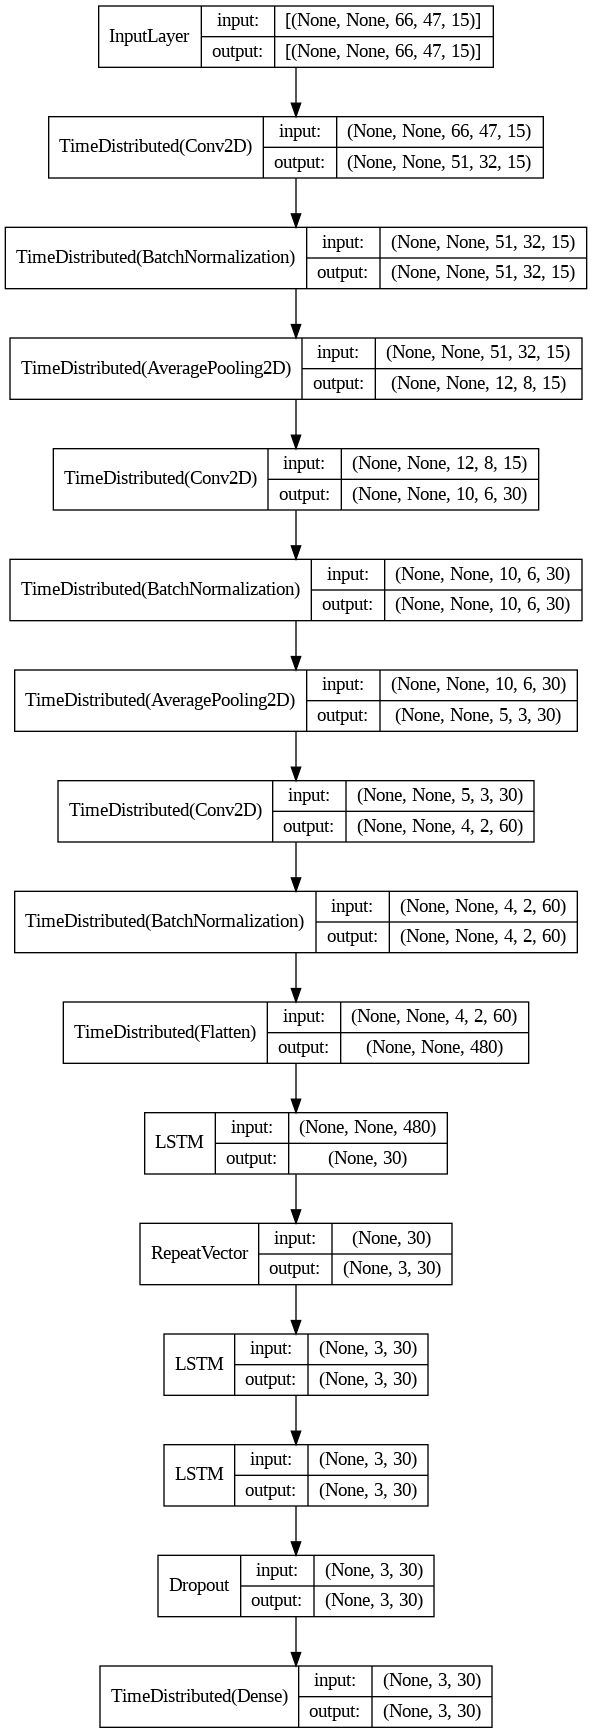

In [48]:

plot_model(model, to_file='lstm_plot.png', show_shapes=True, show_layer_names=False)

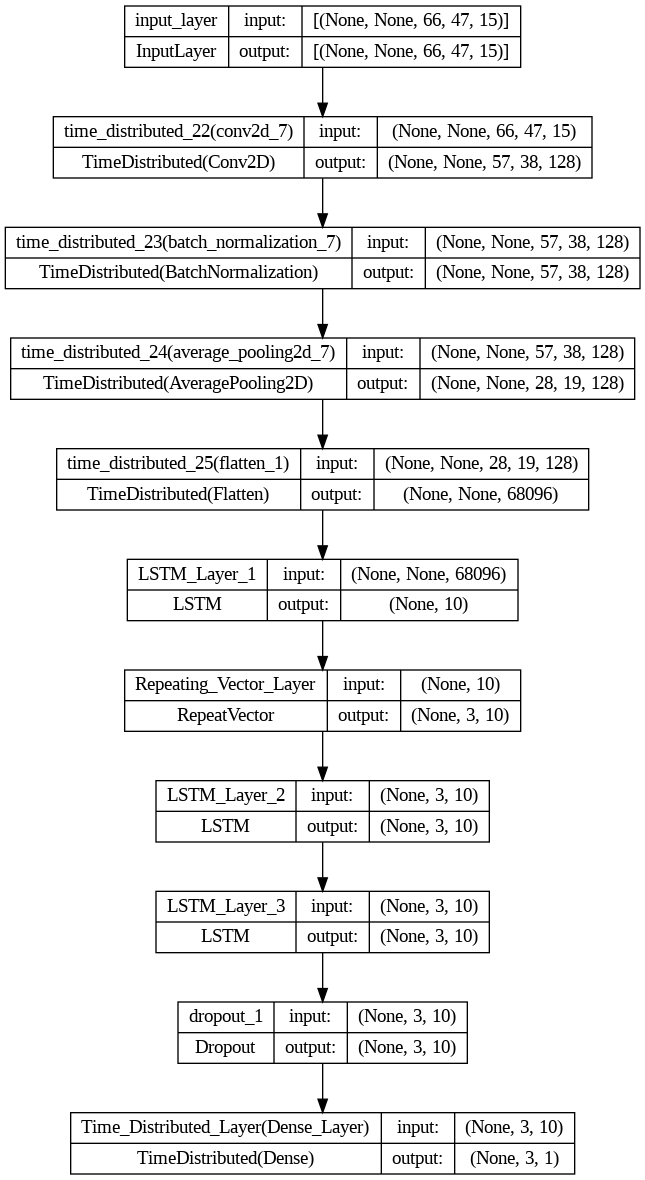

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(cnn_lstm_i.model, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

In [150]:
epochs_count = 200
hist_i = cnn_lstm_i.train(epochs=epochs_count)

Epoch 1/200
15/15 [==============================] - 161s 11s/step - loss: 1.2323 - mean_squared_error: 1.2323 - val_loss: 3192.0503 - val_mean_squared_error: 3192.0503 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 153s 10s/step - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2055 - val_mean_squared_error: 0.2055 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 153s 10s/step - loss: 0.1817 - mean_squared_error: 0.1817 - val_loss: 0.1806 - val_mean_squared_error: 0.1806 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 153s 10s/step - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1561 - val_mean_squared_error: 0.1561 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 153s 10s/step - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.1323 - val_mean_squared_error: 0.1323 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 153s 10s/step - loss: 0.1124 - mean_squared_error: 0.1124 - v

KeyboardInterrupt: 

In [158]:
%reset_selective -f "^cnn_lstm_i$"
# %reset_selective -f "^hist_i$"
%reset_selective -f "^X_train$"
%reset_selective -f "^y_train$"
%reset_selective -f "^X_test$"
%reset_selective -f "^y_test$"


## Predict 

In [266]:
master_scene_test, features_index_test, _ = get_master_scene(date_from_test, date_to_test, cols_to_keep="all", horizons=target_hours_fwd, ufis=target_ufis, values_to_pivot=info_columns, ufi_grid=ufi_grid,ufi_location_summary=ufi_location_summary, scaler=train_feature_scaler)
X_test, y_test = split_sequences_scenes(master_scene_test, n_steps_in, n_steps_out, target_col, features_index_test, portfolio_level=True)

for i in np.arange(0,y_test.shape[1]):
    y_test[:,i,:] = target_scaler.transform(y_test[:,i,:])



2023-02-01 18:30:27,234 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-01 18:30:27,275 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2020-01-01'
2023-02-01 18:30:27,367 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___201904_0.h5', 'premaster_eolic___202005_0.h5', 'premaster_eolic___201907_0.h5', 'premaster_eolic___202110_0.h5', 'premaster_eolic___202101_0.h5', 'premaster_eolic___202002_0.h5', 'premaster_eolic___201905_0.h5', 'premaster_eolic___201903_0.h5', 'premaster_eolic___202107_0.h5', 'premaster_eolic___202206_0.h5', 'premaster_eolic___202004_0.h5', 'premaster_eolic___202204_0.h5', 'premaster_eolic___201902_0.h5', 'premaster_eolic___202003_0.h5', 'premaster_eolic___202105_0.h5', 'premaster_eolic___202108_0.h5', 'premaster_eolic___202007_0.h5', 'premaster_eolic___202008_0.h5', 'premaster_eolic___201910_0.h5', 'premas

In [267]:
from keras.models import load_model
model = load_model('data/cnn_lstm_before_overfitting.hdf5')

In [275]:
#  print(f"Desc of predicted data is: {pd.DataFrame(data[:,1,:]).describe().loc['mean',:3]}")
data = np.nan_to_num(X_test, nan=-1)
predictions = model.predict(data)
predictions = np.where(predictions == -1, np.nan, predictions)

24/24 [==============================] - 12s 489ms/step


In [276]:
np.unique(predictions)

array([0.48734742, 0.49171382, 0.49454182], dtype=float32)

In [277]:
predictions_unscaled = predictions.copy()
for i in np.arange(0,predictions.shape[1]):
    predictions_unscaled[:,i,:] = target_scaler.inverse_transform(predictions[:,i,:])
    
y_test_unscaled = y_test.copy()
for i in np.arange(0,y_test.shape[1]):
    y_test_unscaled[:,i,:] = target_scaler.inverse_transform(y_test[:,i,:])

In [278]:
np.mean(np.abs(y_test_unscaled[:,0,:] - predictions[:,0,:]))

46.81895015275453